# Machine Learning Demonstration

To run this notebook, you need to install python dependencies:

Install tensorflow:

With conda:

```conda install -c conda-forge tensorflow```

With pip:

```pip install tensorflow```

> If you have a GPU in your computer, you can better install the gpu version to speed up some computations by following the instructions in this link: https://www.tensorflow.org/install/

Other dependencies:

With pip:

```
pip install numpy==1.14.0
pip install pandas==0.20.3
pip install matplotlib==2.1.1
pip install Keras==2.0.9
pip install scikit_learn==0.19.1
```

## Using AI Techniques to Forecast GNSS Disruptions

A Global Navigation Satellite System (GNSS) is a network of satellites providing geospatial positioning with global coverage. Such a network relies upon radio communications between satellites and ground-based receivers, which can be subject to interruptions in the presence of extreme space weather events.

Space weather refers to changes in radiation emitted by the Sun, leading to fluctuations in the Earth’s ionosphere. Changes to the electron density in the ionosphere cause fluctuations in the amplitude and phase of radio signals, known as phase scintillation. Radio signals propagating between GNSS satellites and ground-based receivers are affected by these scintillation events and can become inaccurate or even lost. 

In a society that has become dependent on GNSS services for navigation in everyday life, it is important to know when signal disruptions might occur. Given that space weather events occurring between the Sun and the Earth have a non-linear relationship, physical models have struggled to predict scintillation events. One solution is to use artificial intelligence (AI) technologies to create machine learning (ML) models. 

In this notebook, we examine the use of ML models to predict scintiallation events, using historical GNSS data. Initially, a support vector machine (SVM) was used to recreate the baseline model outlined in McGranaghan et al., 2018. We then implement a neural network model in an attempt to improve upon the baseline results. Both methods used the strength of kdb+/q to deal with time-series data and embedPy to import the necessary python ML libraries.


## Data

Publicly available data was used to develop the ML models discussed below. Different datasets describe the state of the Sun, the ionosphere and the magnetic field of the Earth. Combining these datasets created an overall picture of atmospheric conditions at each timestep, including when scintillation events occured.

The first dataset was collected by the Canadian High Arctic Ionospheric Network (CHAIN) from high-latitude GNSS receivers (login required - http://chain.physics.unb.ca/chain/pages/data_download). 14 CHAIN receiver stations with the most continuous data were used. The latitude and longitude of each PolaRxS station can be found on the CHAIN website  (http://chain.physics.unb.ca/chain/pages/stations/). Recorded features for each receiver include; TEC, differential TEC (current TEC minus TEC recorded 15 seconds previously), the scintillation index, the phase and amplitude scintillation indices and the phase spectral slope.

Solar and geomagnetic features can be found in the second dataset, which is available on the NASA OMNI database (ftp://spdf.gsfc.nasa.gov/pub/data/omni/). Features in the data include solar wind properties (velocity, power, and the Newell and Borovsky constants), magnetic properties (magnetic field strength, IMF and clock angle), and geomagnetic indices (AE and SymH), along with proton fluxes and solar X-ray measurements. Additional indices Kp and F10.7 are available from the NOAA Geostationary Satellite Server (https://satdat.ngdc.noaa.gov/sem/goes/data/full/).

The third dataset was collected by magnetometers at high latitudes in the Canadian Array for Real-time Investigations of Magnetic Activity Network (CARISMA) (http://data.carisma.ca/FGM/1Hz/).


## Preprocessing

Initial preprocessing can be found in the script preprocessing.q. CHAIN data was corrected for non-scintillation irregularities by only including data from satellites where lock-times with the receivers were greater than 200 seconds, and where elevation was above 30 degrees. The phase and amplitude scintillation indices were projected to the vertical, to correct for geomagnetic effects in measurements recorded at different elevations. Latitude and longitude for each station were also added to the data. Historical values recorded 15 and 30 minutes previously were included in the Solar dataset for each input parameter from the OMNI dataset.

For all three datasets, datetime columns were added. Solar data which was recorded in 5 and 60 minutes intervals. Given that CHAIN and magnetometer data were recorded at 1 minute intervals for each CHAIN receiver station, station columns were added to each and solar data was forward filled at the missing timesteps to allow consistency across the data.

Once preprocessed, data was persisted as a date-partitioned kdb+ database. Scripts were written to create configuration tables (configSVM.q and configNN.q), specifying the features and scaling required for each model.

## 1 SVM Baseline Model

A SVM will be used to recreate the baseline model outlined in McGranaghan et al., 2018. CHAIN and solar datasets from 2015 are used, with measurements recorded at 1 minute intervals, where CHAIN data is recorded for each of the 14 receiver stations.

### 1.1 Data

In [1]:
\c 12 100
\l /SpaceWeather/kxdb
\l ../utils/utils.q
\l ../utils/graphics.q
\l ../config/configSVM.q

predTime:1 3 6 9 12 24
predCol:`sigPhiVer1hr`sigPhiVer3hr`sigPhiVer6hr`sigPhiVer9hr`sigPhiVer12hr`sigPhiVer24hr

-1"SVM Configuration Table:\n";
show configSVM
-1"\nShape of chain is ",sv[" x "]string(count chain;count cols chain);
-1"Shape of solar is ",sv[" x "]string(count solar;count cols solar);
-1"Shape of goes is ",sv[" x "]string(count goes;count cols goes);

SVM Configuration Table:

table colname   feature scaler
------------------------------
chain dt        0       ::    
chain doy       0       ::    
chain cs        0       ::    
chain tec       1       ::    
chain dtec      1       ::    
chain SI        1       ::    
chain specSlope 1       ::    
..

Shape of chain is 5801091 x 12
Shape of solar is 1576801 x 31
Shape of goes is 520757 x 3


In [2]:
sdateSVM:2015.01.01
edateSVM:2015.12.31

1"Selecting data from ",sv[" - ";string sdateSVM,edateSVM],"\n\n";

getAllDateSVM:{[dt]
  r:tabs!getTabDate[dt;configSVM;]each tabs:`chain`solar`goes;
  t:select from(r[`chain]lj`dt xkey update solarMatch:1b from r`solar)where solarMatch; 
  select from(t lj`dt xkey update goesMatch:1b from r`goes)where goesMatch}
show completeSVM:raze getAllDateSVM peach sdateSVM+til 1+edateSVM-sdateSVM

-1"\nShape of merged chain and solar tables is ",sv[" x "]string shape completeSVM;

Selecting data from 2015.01.01 - 2015.12.31

dt                            doy cs  tec      dtec   SI    specSlope s4         sigPhiVer  Bz   ..
-------------------------------------------------------------------------------------------------..
2015.01.01D00:00:00.000000000 1   arv 16.31073 0.285  0.014 1.77      0.04130524 0.03474961 1.05 ..
2015.01.01D00:00:00.000000000 1   chu 20.58558 0.003  0.009 1.89      0.03389442 0.03238033 1.05 ..
2015.01.01D00:00:00.000000000 1   cor 17.63518 0.072  0.013 2.06      0.04001991 0.0569824  1.05 ..
2015.01.01D00:00:00.000000000 1   edm 26.65708 -0.046 0.01  1.86      0.0443945  0.03070174 1.05 ..
2015.01.01D00:00:00.000000000 1   fsi 27.10333 -0.011 0.008 1.77      0.02914058 0.02512171 1.05 ..
2015.01.01D00:00:00.000000000 1   fsm 21.78102 -0.033 0.009 1.83      0.02766845 0.02570405 1.05 ..
2015.01.01D00:00:00.000000000 1   gil 24.6702  -0.009 0.012 2.06      0.03305384 0.07465466 1.05 ..
..

Shape of merged chain and solar tables is 5748911 x

### 1.2 Target Data
The occurrence of scintillation events are shown by sudden irregularities in a number of features, specifically the phase scintillation index, $\sigma_\phi$, which is projected to the vertical throughout this work (sigPhiVer). As the baseline looks at predicting scintillation 1 hour ahead, the value of $\sigma_\phi$ 1 hour ahead of the current timestep (sigPhiVer1hr) was used as target data for the models.

Ideally, data would have been recorded for each CHAIN station, at every minute throughout 2015. However, receivers can experience faults which lead to timesteps with no recorded data. To examine where these gaps occur in the data, a list containing timesteps for 2015, with minute granularity, can be merged to the full data table, with target values plotted for each timestep.

In [3]:
/import python libraries using embedPy
array: .p.import[`numpy]`:array
plt:   .p.import[`matplotlib]`:pyplot
svc:   .p.import[`sklearn.svm]`:SVC

Phase scintillation index per CHAIN station from 2015.01.01 - 2015.12.31



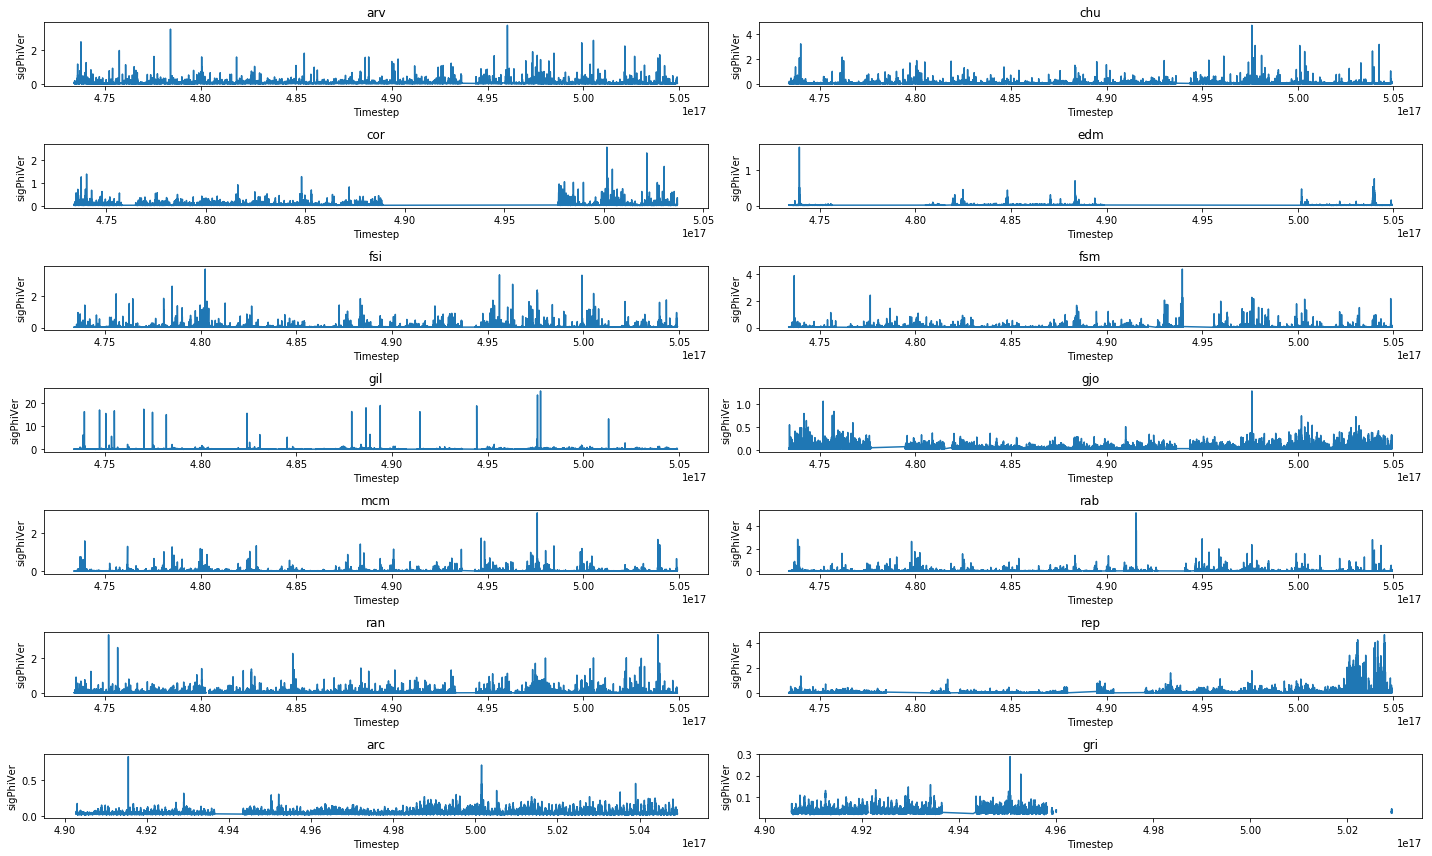

In [4]:
1"Phase scintillation index per CHAIN station from ",(sv[" - "]string(sdateSVM;edateSVM)),"\n\n";

plt[`:figure]`figsize pykw 20 12;
{ stn:(distinct completeSVM`cs)x;
  tab:exec dt,cs,sigPhiVer from completeSVM where cs=stn;
  plt[`:subplot]. 7 2,x+1;
  plt[`:title]string stn;
  plt[`:xlabel]"Timestep";
  plt[`:ylabel]"sigPhiVer";
  plt[`:plot][tab`dt;tab`sigPhiVer];
 }each til 14;

plt[`:tight_layout][];
plt[`:show][];

### 1.3 Extra Features
Scintillation events are subject to seasonal variations. To account for this, the sine and cosine time of day and day of year were added to the data. For the baseline, only the cosine day of year is added.

$$\begin{eqnarray}
cosdoy = cos\Big(\frac{2 \pi doy}{D_{tot}}\Big), && sindoy = sin\Big(\frac{2 \pi doy}{D_{tot}}\Big)
\end{eqnarray}$$
$$ $$
$$\begin{eqnarray}
costime = cos\Big(\frac{2 \pi dt}{T_{tot}}\Big), && sintime = sin\Big(\frac{2 \pi dt}{T_{tot}}\Big)
\end{eqnarray}$$

where $doy$ is the day of year, $D_{tot}$ is the number of days in the year (365 for this model), $dt$ is the time in minutes and $T_{tot}$ is the number of minutes in a day. The feature names must be added to the configuration table, with relevant scaling, to allow for scaling at a later stage.

In [5]:
completeSVM:update cosdoy:cos 2*pi*doy%365 from completeSVM
configSVM,:(`completeSVM;`cosdoy;1b;log1p)

In [6]:
/add target columns for each prediction time
completeSVM:predVal/[completeSVM;predTime]

### 1.4 Feature Engineering
To account for gaps in the data, rows containing nulls will be dropped. As ML models are sensitive to inputs with large ranges, some features in the input data were log(1+x) scaled (as defined in the SVM configuration table). All features will be standard scaled at a later stage, before feeding the data to the SVM classifier.

In [9]:
completeSVM@:where not any flip null completeSVM
completeSVM:flip(exec first scaler by colname from configSVM)@'flip completeSVM

-1"Scintillation events:\n";
show distSVM:update pcnt:round[;.01]100*num%sum num from select num:count i by scintillation from([]scintillation:.1<completeSVM`sigPhiVer)
-1"\n",(string first exec pcnt from select pcnt from distSVM where scintillation)," percent of the target values represent scintillation occurring.";

Scintillation events:

scintillation| num   pcnt 
-------------| -----------
0            | 87818 97.26
1            | 2473  2.74 

2.74 percent of the target values represent scintillation occurring.


In [10]:
/separate data
show svmData:(`ALL,stn)!enlist[-40000?completeSVM],{select from completeSVM where cs=x}each stn:distinct completeSVM`cs

ALL| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
arv| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
chu| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
cor| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
edm| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
fsi| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
fsm| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
gil| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
gjo| +`AE`AE_15`AE_30`By`By_15`By_30`Bz`Bz_15`Bz_30`GOESx`P`P_15`P_30`SI`V`V_15`V_30`borovsky`bor..
..


### 1.5 Metrics
As only 3% of the data represented scintillation occuring, it would have been easy to create a model which produced high accuracy. A naive model which predicted that scintillation never occured would still have been correct 97% of the time. Additional metrics, including the Total Skill Statistic (TSS) will be used to determine how well the models perform.
$$\begin{equation}TSS=\frac{TP}{TP+FN}-\frac{FP}{FP+TN}\end{equation}$$

where $TP$, $TN$, $FP$ and $FN$ are true positives, true negatives, false positives and false negatives respectively.

### 1.6 Running model for ARV station
Initially, two sets of shuffled indices are produced, covering the full set of indices in the data. These indices will then be used to split x and y data into split into training (80%) and testing (20%) sets.

X data is selected according to the SVM configuration table and y data is sigmaPhiVer1hr to allow 1 hour prediction. Standard scaling will be applied to x data to remove the mean and scale each feature to unit variance. Meanwhile, target data will be left unscaled and assigned a binary value.

When scintillation events take place, $\sigma_\phi$ will have a value which is greater than 0.1 radians. Therefore, target data will be assigned a value of 1 if greater than 0.1 radians (positive class) and 0 with a value below (negative class).

In [11]:
\S 10
sampleSVM:t neg[c]?c:count t:svmData`arv
xSVM:flip stdscaler each flip(exec colname from configSVM where feature)#sampleSVM
ySVM:.1<sampleSVM first predCol
svmInputs:`xtrn`ytrn`xtst`ytst!raze(xSVM;ySVM)@\:/:splitIdx[.2;ySVM]

In [12]:
-1"Scintillation events in testing set:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:svmInputs`ytst)
-1"\nScintillation events in training set:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:svmInputs`ytrn)

Scintillation events in testing set:

ybinary| num  pcnt 
-------| ----------
0      | 1569 98.37
1      | 26   1.63 

Scintillation events in training set:

ybinary| num  pcnt 
-------| ----------
0      | 6253 97.95
1      | 131  2.05 


In [13]:
start:.z.T;
svmModel:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
svmModel[`:fit][array[value flip svmInputs`xtrn]`:T;svmInputs`ytrn];
-1"Training SVM model for a single station took ",string .z.T-start;

Training SVM model for a single station took 00:00:14.529


Now that the model has been trained, it will can be used to make predictions using test data. These predictions will be compared with y test values using a confusion matrix.

In [14]:
svmPred:svmModel[`:predict][array[value flip svmInputs`xtst]`:T]`
-1"Confusion matrix results for SVM model trained/tested on ARC:\n";
show svmCM:cfm[svmInputs`ytst;svmPred]
-1"\nPerformance metric results:\n";
show(`model`cs`pred!(`SVM;`arc;first predCol)),metrics svmCM

Confusion matrix results for SVM model trained/tested on ARC:

0| 1249 7 
1| 320  19

Performance metric results:

model      | `SVM
cs         | `arc
pred       | `sigPhiVer1hr
accuracy   | 79.49843
errorRate  | 20.50157
precision  | 5.60472
recall     | 73.07692
specificity| 79.60484
TSS        | 0.5268177


### 1.7 Running model for all stations and prediction times

In [15]:
\S 20
trainPredSVM:{[stn;col]

  sample:t neg[c]?c:count t:svmData stn;
  xdata:flip stdscaler each flip(exec colname from configSVM where feature)#sample;
  ydata:.1<sample col;
  r:`xtrn`ytrn`xtst`ytst!raze(xdata;ydata)@\:/:splitIdx[.2;ydata];

  start:.z.T;
  model:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
  if[(::)~ .[model[`:fit];(array[value flip r`xtrn]`:T;r`ytrn);{[e] -2"Error: ",e;}];:()];
  -1"Training SVM model for a single station took ",string .z.T-start;

  pred:model[`:predict][array[value flip r`xtst]`:T]`; 
  CM:cfm[r`ytst;pred];
  (`model`cs`pred!(`SVM;stn;col)),metrics CM

  }

The baseline model uses combined data from all stations. Therefore, the model will first be trained and tested using combined data, and then run using data from individual stations.

In [16]:
start:.z.T;
svmRes:trainPredSVM . '(`ALL,stn)cross first predCol
-1"Total SVM training time: ",string .z.T-start;

Training SVM model for a single station took 00:15:54.808
Training SVM model for a single station took 00:00:14.097
Training SVM model for a single station took 00:00:12.924
Training SVM model for a single station took 00:00:07.655
Training SVM model for a single station took 00:00:00.828
Training SVM model for a single station took 00:00:11.540
Training SVM model for a single station took 00:00:09.176
Training SVM model for a single station took 00:00:21.790
Training SVM model for a single station took 00:00:15.846
Training SVM model for a single station took 00:00:10.686
Training SVM model for a single station took 00:00:08.410
Training SVM model for a single station took 00:00:15.591
Training SVM model for a single station took 00:00:15.902
Training SVM model for a single station took 00:00:02.824
Training SVM model for a single station took 00:00:00.029
Total SVM training time: 00:18:42.334


In [17]:
svmRes

model cs  pred         accuracy errorRate precision recall   specificity TSS      
----------------------------------------------------------------------------------
SVM   ALL sigPhiVer1hr 73.5375  26.4625   8.446986  84.21053 73.2244     0.5743492
SVM   arv sigPhiVer1hr 77.68025 22.31975  5.913978  78.57143 77.66433    0.5623576
SVM   chu sigPhiVer1hr 87.04857 12.95143  7.305936  76.19048 87.19243    0.6338291
SVM   cor sigPhiVer1hr 64.82364 35.17636  5.181347  86.95652 64.32749    0.5128401
SVM   edm sigPhiVer1hr 96.5866  3.413401  15.625    100      96.56489    0.9656489
SVM   fsi sigPhiVer1hr 89.07615 10.92385  10.10638  76       89.28345    0.6528345
SVM   fsm sigPhiVer1hr 88.2     11.8      7.386364  48.14815 88.93415    0.370823 
..


### 1.8 MCM model
Train the SVM model using shuffled points from the Fort McMurray (mcm) station and test shuffled points from each of the remaining stations.

In [18]:
\S 30
sampleMCM:m neg[c]?c:count m:svmData`mcm;
xtrnMCM:flip stdscaler each flip(exec colname from configSVM where feature)#sampleMCM;
ytrnMCM:.1<sampleMCM first predCol;

start:.z.T;
mcmModel:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
mcmModel[`:fit][array[value flip xtrnMCM]`:T;ytrnMCM];
-1"Training SVM model for MCM station took ",string .z.T-start;

Training SVM model for MCM station took 00:00:15.820


In [19]:
\S 40
predMCM:{[stn;col]

  sampleTst:r neg[c]?c:count r:svmData stn;
  xtst:flip stdscaler each flip(exec colname from configSVM where feature)#sampleTst;
  ytst:.1<sampleTst col;

  start:.z.T;
  pred:mcmModel[`:predict][array[value flip xtst]`:T]`;
  -1"Testing SVM model for a single station took ",string .z.T-start;

  CM:cfm[ytst;pred];
  (`model`cs`pred!(`MCM;stn;col)),metrics CM

  }

In [20]:
start:.z.T;
mcmRes:predMCM . 'except[stn;`mcm]cross first predCol
-1"Total MCM model training time: ",string .z.T-start;

Testing SVM model for a single station took 00:00:01.941
Testing SVM model for a single station took 00:00:01.989
Testing SVM model for a single station took 00:00:01.265
Testing SVM model for a single station took 00:00:00.964
Testing SVM model for a single station took 00:00:01.961
Testing SVM model for a single station took 00:00:01.844
Testing SVM model for a single station took 00:00:01.891
Testing SVM model for a single station took 00:00:01.815
Testing SVM model for a single station took 00:00:01.773
Testing SVM model for a single station took 00:00:01.911
Testing SVM model for a single station took 00:00:01.603
Testing SVM model for a single station took 00:00:00.906
Testing SVM model for a single station took 00:00:00.278
Total MCM model training time: 00:00:20.690


In [22]:
mcmRes

model cs  pred         accuracy errorRate precision recall   specificity TSS      
----------------------------------------------------------------------------------
MCM   arv sigPhiVer1hr 83.28111 16.71889  6.759735  58.59873 83.77653    0.4237525
MCM   chu sigPhiVer1hr 84.09063 15.90937  6.410256  69.67213 84.31298    0.5398511
MCM   cor sigPhiVer1hr 82.63108 17.36892  7.908992  54.47761 83.3692     0.3784682
MCM   edm sigPhiVer1hr 88.30513 11.69487  4.375     84       88.33249    0.7233249
MCM   fsi sigPhiVer1hr 83.66201 16.33799  6.569343  75.63025 83.7831     0.5941335
MCM   fsm sigPhiVer1hr 84.14667 15.85333  6.451613  73.3945  84.30524    0.5769973
MCM   gil sigPhiVer1hr 80.73025 19.26975  26.54176  38.54875 86.1902     0.2473895
MCM   gjo sigPhiVer1hr 82.53134 17.46866  13.0988   56.45161 83.66859    0.401202 
MCM   rab sigPhiVer1hr 84.86722 15.13278  7.807018  77.3913  84.99       0.6238131
MCM   ran sigPhiVer1hr 82.75556 17.24444  6.788321  53.44828 83.41774    0.3686601
MCM 

### Results

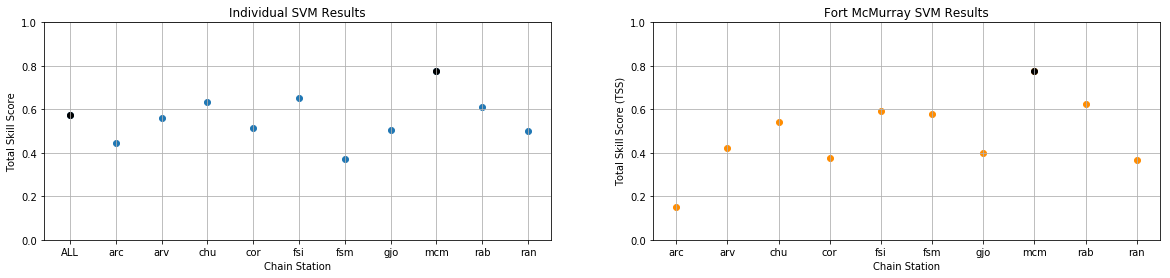

In [23]:
resplot[svmRes;mcmRes]

The baseline model which combines data from all CHAIN stations gives a relatively average accuracy of 76.98%. However, this model produces a low TSS of 0.5816 (precision = 8.806%, recall = 81.31%). The above plots contain TSS values for the different methods used. The left plot shows how the performance of the model varied depending on which station was used to train and test the SVM. The Fort McMurray (mcm) model shown on the right produces worse results, with results varying even more drastically from station to station.

From these results we can infer that scintillation events must be localized. To train a model with higher accuracy and TSS, data must either be separated on a station-by-station basis, or additional spatial parameters must be introduced to account for the geospatial elements in the data.

## 2 Neural Network (NN) Model
To improve performance metrics, a neural network model will be used. Going forward, only components selected in the feature selection process (featureselection.ipynb) will be used (found in the NN configuration table).

As results showed that scintillation events are localized, localized features will be added to the dataset to account for the position of each station. These included the magnetometer dataset along with additional features mentioned below.
### 2.1 Data

In [24]:
\c 12 110
\l ../config/configNN.q

In [25]:
sdateNN:2015.01.01
edateNN:2015.12.31

1"Selecting data from ",sv[" - ";string sdateNN,edateNN],"\n\n";

getAllDateNN:{[dt]
  r:tabs!getTabDate[dt;configNN;]each tabs:`chain`solar`goes`mag;
  t1:select from(r[`chain]lj`dt xkey update solarMatch:1b from r`solar)where solarMatch; 
  t2:select from(t1 lj`dt xkey update goesMatch:1b from r`goes)where goesMatch;
  select from(t2 lj`dt`cs xkey update magMatch:1b from r`mag)where magMatch}
show completeNN:raze getAllDateNN peach sdateNN+til 1+edateNN-sdateNN

-1"\nShape of merged chain and solar tables is ",sv[" x "]string shape completeNN;

Selecting data from 2015.01.01 - 2015.12.31

dt                            doy cs  tec      dtec   SI    specSlope s4         sigPhiVer  lat      long  ..
-----------------------------------------------------------------------------------------------------------..
2015.01.01D00:00:00.000000000 1   chu 20.58558 0.003  0.009 1.89      0.03389442 0.03238033 58.75928 -94.08..
2015.01.01D00:00:00.000000000 1   mcm 26.4495  -0.009 0.007 1.82      0.02682024 0.02189605 56.64954 -111.2..
2015.01.01D00:01:00.000000000 1   chu 23.5022  0      0.008 1.86      0.03101697 0.02482456 58.75928 -94.08..
2015.01.01D00:01:00.000000000 1   mcm 28.21376 -0.042 0.006 1.79      0.02449711 0.02454222 56.64954 -111.2..
2015.01.01D00:02:00.000000000 1   chu 22.22837 -0.006 0.009 1.94      0.03004769 0.02475049 58.75928 -94.08..
2015.01.01D00:02:00.000000000 1   mcm 27.80834 -0.043 0.006 1.86      0.02343506 0.02284805 56.64954 -111.2..
2015.01.01D00:03:00.000000000 1   chu 23.701   -0.014 0.01  1.87      0.031

### 2.2 Extra Features
As mentioned above, extra columns sindoy, cosdoy, sintime and cosdoy were added to account for variations in the data. In this model, 365.25 is used for $D_{tot}$ to account for the extra day present in a leap year. The names of the new features are added to the NN configuration table to account for scaling at a later stage. 

In [26]:
a:{2*pi*x%365.25}
b:{(2*pi*`int$`minute$x)%1440}
completeNN:update sindoy:sin a[doy],cosdoy:cos a[doy],sintime:sin b[dt],costime:cos b[dt]from completeNN
{configNN,:(x;y;1b;z)}'[4#`completeNN;`sindoy`cosdoy`sintime`costime;(log1p;log1p;(::);(::))];

When a scintillation event occurs, geomagnetic features such as the x, y and z components of the Earth's magnetic field and dtec will fluctuate drastically, shown in the plot below. 

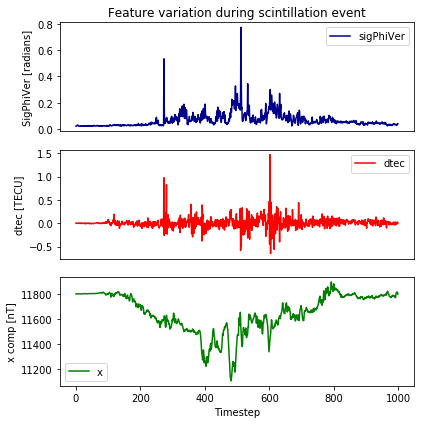

In [27]:
scintplot[completeNN]

In [28]:
newval:{abs(x-avg x)}
completeNN:update newx:newval x,newy:newval y,newz:newval z,newdtec:newval dtec from completeNN
{configNN,:(x;y;1b;z)}'[4#`completeNN;`newx`newy`newz`newdtec;4#(::)];

In [29]:
/add target columns for each prediction time
completeNN:predVal/[completeNN;predTime]

### 2.3 Feature Engineering
Following the same method as the SVM model, nulls will be dropped, with features scaled.

In [30]:
completeNN@:where not any flip null completeNN

In [31]:
/separate data
show dataNN:(`ALL,nnStn)!(enlist[completeNN],{?[completeNN;enlist(in;`cs;enlist x);0b;()]}each nnStn:distinct completeNN`cs)

ALL| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_30`newell`..
chu| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_30`newell`..
mcm| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_30`newell`..
fsi| +`dt`doy`cs`tec`dtec`SI`specSlope`s4`sigPhiVer`lat`long`V`V_15`V_30`P`P_15`P_30`AE`AE_15`AE_30`newell`..


### 2.4  Running model for MCM
For the NN model, features will be exponentially weighted to give more recent data the highest importance. Target data will also be log scaled to prevent negative predictions for $\sigma_\phi$, which is always positive. A train-test split of 80%-20% will again be used.

In [32]:
\S 50
scaledNN:flip(exec first scaler by colname from configNN)@'flip dataNN`mcm
xNN:flip stdscaler each flip(exec colname from configNN where feature)#scaledNN
xNN:flip(reverse ema[.1]reverse@)each flip xNN
yNN:log scaledNN[first predCol]
nnInputs:`xtrn`ytrn`xtst`ytst!raze(xNN;yNN)@\:/:splitIdx[.2;yNN]

To overcome the small fraction of data representing scintillation events, oversampling is used on the training set. A random sample taken from the positive class and re-added to the training dataset, giving a final training set with 50% positive samples.

In [33]:
\S 60
positiveIdx:where yscint:.1<exp nnInputs`ytrn
pos:`x`y!{x[y]}[;positiveIdx]each(nnInputs`xtrn;nnInputs`ytrn)
sampleIdx:(nadd:(-) . sum each yscint=/:(0 1))?count pos`x
sample:`x`y!{x[y]}[;sampleIdx]each(pos`x;pos`y)
oversampled:`x`y!(nnInputs`xtrn;nnInputs`ytrn),'(sample`x;sample`y)

-1"Scintillation events in training set before oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:yscint)
-1"\nScintillation events in training set after oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:.1<exp oversampled`y)
-1"\nScintillation events in training set:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:.1<exp nnInputs`ytst)

Scintillation events in training set before oversampling:

ybinary| num  pcnt
-------| ---------
0      | 6284 97.9
1      | 135  2.1 

Scintillation events in training set after oversampling:

ybinary| num  pcnt
-------| ---------
0      | 6284 50  
1      | 6284 50  

Scintillation events in training set:

ybinary| num  pcnt 
-------| ----------
0      | 1560 97.26
1      | 44   2.74 


### 2.4 Model
We can use embedPy to import the python libraries necessary for creating the NN.

In [35]:
sequential:    .p.import[`keras.models]`:Sequential
dense:         .p.import[`keras.layers]`:Dense
normalization: .p.import[`keras.layers]`:BatchNormalization
pylist:        .p.import[`builtins]`:list

The model has 1 input layer, 4 hidden layers and 1 output layer. A normal distribution is used as the initializer for the kernel to set the weights in each layer of the model.

The input and hidden layers have output widths of 256 nodes, along with an Exponential Linear Unit (ELU) activation function, which gives the best model performance. ELU was specifically chosen as it converged the loss function to zero better than other activation functions, such as a Rectified Linear Unit (RELU).

The output layer has 1 node and a linear activation function to allow a single value for $\sigma_\phi$ to be returned for each timestep.

In [37]:
nnModel:sequential[];
nnModel[`:add]dense[256;`input_dim pykw 37;`kernel_initializer pykw`normal;`activation pykw`elu];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
nnModel[`:add]normalization[];
nnModel[`:add]dense[1;`activation pykw`linear];
nnModel[`:compile][`loss pykw`mean_squared_error;`optimizer pykw`adam;`metrics pykw pylist `mse`mae]; 

We can now train the model for 50 epochs, using batch sizes of 512 each time. The model performs validation using 20% of the training data.

In [38]:
epochs:30
batchsz:512

In [39]:
start:.z.T;
res:nnModel[`:fit][array[value flip oversampled`x]`:T;oversampled`y;`batch_size pykw batchsz;`verbose pykw 3;`epochs pykw epochs;`validation_split pykw .2];
-1"Training sequential model for ",string[epochs]," epochs took ",string .z.T-start;

Train on 10054 samples, validate on 2514 samples
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Training sequential model for 30 epochs took 00:00:25.627


In [40]:
show hist:6#(res[`:history]`)

val_loss               | 2.997662 2.105026 1.217908 0.392631  0.1053904 0.2458893 0.540226  0.5958511 0.559..
val_mean_squared_error | 2.997662 2.105026 1.217908 0.392631  0.1053904 0.2458893 0.540226  0.5958511 0.559..
val_mean_absolute_error| 1.705815 1.423599 1.070957 0.5741345 0.2417282 0.3916746 0.6651821 0.7061076 0.682..
loss                   | 9.876172 6.070695 4.220662 2.584486  1.284653  0.4902234 0.1791081 0.1251267 0.109..
mean_squared_error     | 9.876172 6.070695 4.220662 2.584486  1.284653  0.4902234 0.1791081 0.1251267 0.109..
mean_absolute_error    | 2.883775 2.412373 2.009554 1.554019  1.059831  0.6040517 0.3207201 0.2602456 0.241..


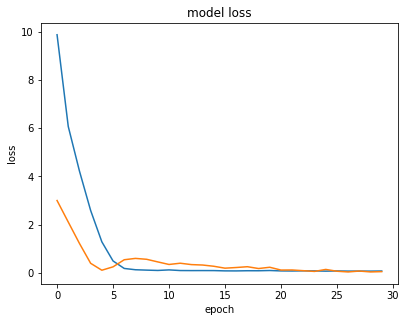

In [41]:
plt[`:plot]hist`loss;
plt[`:plot]hist`val_loss;
plt[`:title]"model loss";
plt[`:ylabel]"loss";
plt[`:xlabel]"epoch";
plt[`:show][];

Once trained, the model can be used to make predictions 1 hour ahead. Outputs will be assigned binary values, using the 0.1 radians threshold, and can then be compared to the y test values selected previously.

In [42]:
nnPred:raze(nnModel[`:predict]array[value flip nnInputs`xtst]`:T)`
value`predVal`binpredVal!(exp nnPred;.1<exp nnPred)

0.02246206 0.02236239 0.03386625 0.02151203 0.03269459 0.02159308 0.02496892 0.02581702 0.02240236 0.040265..
0          0          0          0          0          0          0          0          0          0       ..



Confusion matrix for neural network model:



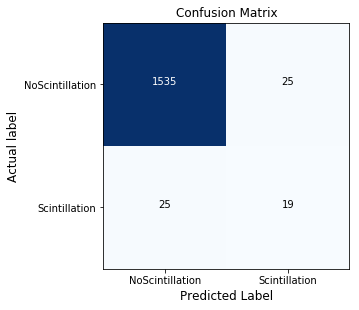

In [43]:
-1"\nConfusion matrix for neural network model:\n";
nnCM:cfm[.1<exp nnInputs`ytst;.1<exp nnPred]
displayCM[value nnCM;`NoScintillation`Scintillation;"Confusion Matrix";()]

In [44]:
-1"Performance metric results:\n";
show(`model`cs`pred!(`NN;`mcm;first predCol)),metrics nnCM

Performance metric results:

model      | `NN
cs         | `mcm
pred       | `sigPhiVer1hr
accuracy   | 96.88279
errorRate  | 3.117207
precision  | 43.18182
recall     | 43.18182
specificity| 98.39744
TSS        | 0.4157925


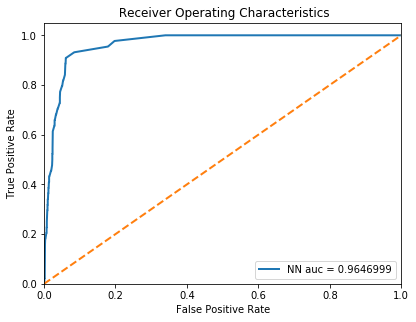

In [45]:
rocplot[nnInputs`ytst;nnPred]

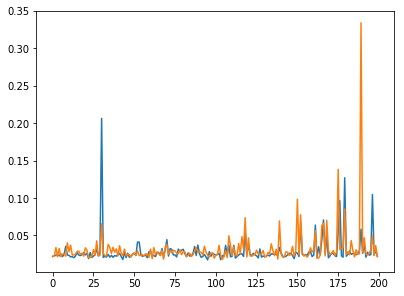

In [46]:
plt[`:plot][200#exp nnInputs`ytst];
plt[`:plot][200#exp nnPred];
plt[`:show][];

### 2.5 Running model for all stations and prediction times

In [47]:
\S 70
trainPredNN:{[stn;col]

  scl:flip(exec first scaler by colname from configNN)@'flip t:dataNN[stn];
  xdata:flip stdscaler each flip(exec colname from configNN where feature)#scl;
  xdata:flip(reverse ema[.1]reverse@)each flip xdata;
  ydata:log t[col];
  r:`xtrn`ytrn`xtst`ytst!raze(xdata;ydata)@\:/:splitIdx[.2;ydata];

  positiveIdx:where yscint:.1<exp r`ytrn;
  pos:`x`y!{x[y]}[;positiveIdx]each(r`xtrn;r`ytrn);
  sampleIdx:(nadd:(-) . sum each yscint=/:(0 1))?count pos`x;
  sample:`x`y!{x[y]}[;sampleIdx]each(pos`x;pos`y);
  oversampled:`x`y!(r`xtrn;r`ytrn),'(sample`x;sample`y);

  start:.z.T;
  nnModel[`:fit][array[value flip oversampled`x]`:T;oversampled`y;`batch_size pykw batchsz;`verbose pykw 0;`epochs pykw epochs;`validation_split pykw .2];
  -1"Training sequential model for ",string[epochs]," epochs took ",string .z.T-start;

  pred:raze(nnModel[`:predict]array[value flip r`xtst]`:T)`;
  CM:cfm[.1<exp r`ytst;.1<exp pred];
  (`model`cs`pred!(`NN;stn;col)),metrics CM

  }

In [48]:
start:.z.T;
nnRes:trainPredNN . '(`ALL,distinct completeNN`cs)cross first predCol
-1"Total NN training time: ",string .z.T-start;

Training sequential model for 30 epochs took 00:01:05.809
Training sequential model for 30 epochs took 00:00:24.064
Training sequential model for 30 epochs took 00:00:24.604
Training sequential model for 30 epochs took 00:00:13.617
Total NN training time: 00:02:09.351


In [49]:
\c 100 100
nnRes

model cs  pred         accuracy errorRate precision recall   specificity TSS      
----------------------------------------------------------------------------------
NN    ALL sigPhiVer1hr 97.21116 2.788845  15.47619  24.07407 98.20798    0.2228205
NN    chu sigPhiVer1hr 97.49357 2.506427  5.882353  4.166667 98.95561    0.0312228
NN    mcm sigPhiVer1hr 97.56858 2.431421  42.85714  44.11765 98.72611    0.4284376
NN    fsi sigPhiVer1hr 97.54386 2.45614   33.33333  23.52941 99.04535    0.2257476


### Comparison of results

In [50]:
\c 50 100
svm124:select from svmRes where pred in`sigPhiVer1hr`sigPhiVer24hr
nn124:select from nnRes where pred in`sigPhiVer1hr`sigPhiVer24hr
`cs`pred xasc select from(svm124,nn124)where cs in(`ALL,distinct completeNN`cs)

model cs  pred         accuracy errorRate precision recall   specificity TSS      
----------------------------------------------------------------------------------
SVM   ALL sigPhiVer1hr 73.5375  26.4625   8.446986  84.21053 73.2244     0.5743492
NN    ALL sigPhiVer1hr 97.21116 2.788845  15.47619  24.07407 98.20798    0.2228205
SVM   chu sigPhiVer1hr 87.04857 12.95143  7.305936  76.19048 87.19243    0.6338291
NN    chu sigPhiVer1hr 97.49357 2.506427  5.882353  4.166667 98.95561    0.0312228
SVM   fsi sigPhiVer1hr 89.07615 10.92385  10.10638  76       89.28345    0.6528345
NN    fsi sigPhiVer1hr 97.54386 2.45614   33.33333  23.52941 99.04535    0.2257476
SVM   mcm sigPhiVer1hr 86.70377 13.29623  15.93625  90.90909 86.58614    0.7749523
NN    mcm sigPhiVer1hr 97.56858 2.431421  42.85714  44.11765 98.72611    0.4284376
